In [84]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep


## Convolution

In [85]:
single=np.array([[[[5,0,8,7,8,1],
                   [1,9,5,0,7,7],
                   [6,0,2,4,6,6],
                   [9,7,6,6,8,4],
                   [8,3,8,5,1,3],
                   [7,2,7,0,1,0]]]])

single.shape

(1, 1, 6, 6)

In [86]:
identity=np.array([[0,0,0],
                  [0,1,0],
                  [0,0,0]])
identity=identity.reshape(1,1,3,3)
identity.shape

(1, 1, 3, 3)

### Convolving (Applying filters)

In [87]:
region=single[:,:,:3,:3] # NCHW shape

filtered_region=region*identity
total=filtered_region.sum()
total

9

The size of the movement in pixels called `stride`

In [88]:
new_region=single[:,:,:3,1:4]
new_filtered_region=new_region*identity
new_total=new_filtered_region.sum()
new_total

5

The larger the filter, smaller the resulting image  

$(h_i,w_i)*(h_f,w_f)=(h_i-(h_f-1),w_i-(w_f-1))$
$\\(h_i,w_i)*f=(h_i-f+1,w_i-f+1)$


## Convolving in Pytorch

In [89]:
image=torch.as_tensor(single).float()
kernel_identity=torch.as_tensor(identity).float()

Functional convolution

In [90]:
convolved=F.conv2d(image,kernel_identity,stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

Convolutional module: Learn kernel/filter on its own

In [91]:
conv=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1)
conv(image)

tensor([[[[3.2911, 3.5048, 6.1245, 7.9004],
          [5.3625, 7.1165, 5.2145, 5.2698],
          [5.9949, 4.5676, 4.3590, 4.7601],
          [7.1711, 6.1960, 4.1235, 3.9785]]]], grad_fn=<ConvolutionBackward0>)

Learn multiple filters at once


In [92]:
conv_multiple=nn.Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.0750,  0.1961, -0.0058],
          [ 0.0863, -0.1416,  0.0161],
          [ 0.2911,  0.0700,  0.0526]]],


        [[[-0.2307, -0.2220, -0.2203],
          [ 0.3204, -0.2839, -0.3209],
          [-0.1486, -0.1137, -0.1860]]]], requires_grad=True)

Use convolutional module to use particular weights

In [93]:
with torch.no_grad():
    conv.weight[0]=kernel_identity
    conv.bias[0]=0

conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

$(h_i,w_i)*f=(\frac{h_i-f+1}{s},\frac{w_i-f+1}{s})$

In [94]:
convolution_stride2=F.conv2d(image,kernel_identity,stride=2)
convolution_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

## Padding; to preserve original size of the image after convolution
Expand the input image: Add zero rows and columns around the image

In [95]:
# symmetric padding
constant_padder=nn.ConstantPad2d(padding=1,value=0.0) # padding: num of columns and rows to be stuffed, value: value that filling the new cols and rows
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [96]:
constant_padder(image).shape

torch.Size([1, 1, 8, 8])

In [97]:
# asymetric padding(change pad)
asy_padded=F.pad(image,pad=(1,1,1,1),mode='constant',value=0) # pad=(left,right, top, bottom)
asy_padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

Other padding modes: replicate, reflect, circular

In [98]:
replication_padder=nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [99]:
reflection_padder=nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [100]:
circular_padding=nn.CircularPad2d(padding=1)
circular_padding(image)

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

$(h_i,w_i)*f=(\frac{h_i+2p-f+1}{s},\frac{w_i+2p-f+1}{s})$

In [101]:
edge=np.array([[[[0,1,0],
                 [1,-4,1],
                 [0,1,0]]]])

kernel_edge=torch.as_tensor(edge).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

In [102]:
padded_image=F.pad(image,pad=(1,1,1,1),mode='constant',value=0.0)
conv_padded=F.conv2d(input=padded_image,weight=kernel_edge,stride=1)
conv_padded

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

## Pooling: Shrinking images

In [103]:
pooled=F.max_pool2d(input=conv_padded,kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [104]:
# 4x4 pooling
maxpool4=nn.MaxPool2d(kernel_size=4)
maxpool4(conv_padded)

tensor([[[[24.]]]])

In [105]:
F.max_pool2d(input=conv_padded,kernel_size=3,stride=1)

tensor([[[[24., 24., 23., 23.],
          [24., 24., 23., 23.],
          [24., 24., 13., 13.],
          [13., 13., 13., 13.]]]])

## Flattening

In [106]:
flattened=nn.Flatten(1,-1)(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [107]:
pooled.view(1,-1)

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

## Typical Architecture  

**Typical Convolutional block**: Preprocessing images and coverting them into features
1. Convolution
2. Activation function
3. Pooling

In [108]:
# LeNet-5
lenet=nn.Sequential()

# Featurizer
# block 1: 1@28x28-->6@28x28-->6@14x14
lenet.add_module('conv2d1',nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding=2))
lenet.add_module('activation1',nn.ReLU())
lenet.add_module('maxpool2d1',nn.MaxPool2d(kernel_size=2))

# block 2: 6@14x14-->16@10x10-->16@5x5
lenet.add_module('conv2d2',nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5))
lenet.add_module('activation2',nn.ReLU())
lenet.add_module('maxpool2d2',nn.MaxPool2d(kernel_size=2))

# block 3: 16@5x5-->120@1x1
lenet.add_module('conv2d3',nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5))
lenet.add_module('activation3',nn.ReLU())
lenet.add_module('flatten',nn.Flatten())

# Classification
# Hidden layer
lenet.add_module('linear1',nn.Linear(in_features=120,out_features=84))
# output layer
lenet.add_module('linear2',nn.Linear(in_features=84,out_features=10))

In [109]:
lenet

Sequential(
  (conv2d1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation1): ReLU()
  (maxpool2d1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (activation2): ReLU()
  (maxpool2d2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (activation3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)

# Multiclass Classification

### Data Generation  

Parallel(Horizontal or vertical) ---> 0  
Diagonal(Tilted to the right) ---> 1  
Diagonal(Tileted to the left) ---> 2  




In [110]:
images,labels=generate_dataset(img_size=10,n_images=1000,binary=False,seed=17)

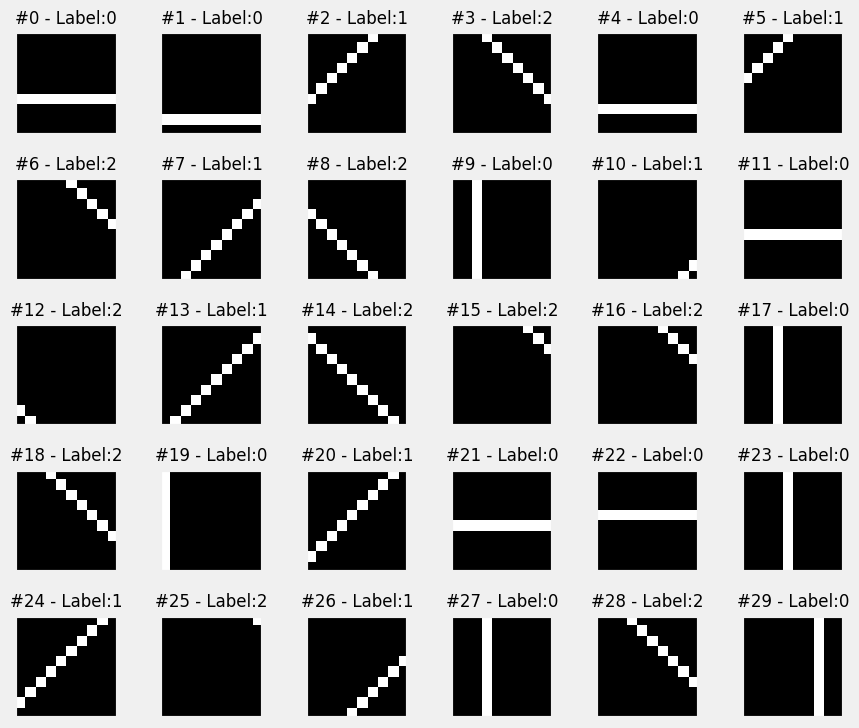

In [111]:
fig=plot_images(images,labels,n_plot=30)

### Transformed Dataset

In [112]:
class TransformedTensorDataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __getitem__(self,index):
        x=self.x[index]
        if self.transform:
            x=self.transform(x)
        return x,self.y[index]
    
    def __len__(self):
        return len(self.x)

### Data preparation